In [1]:
'''current progress:

I can calculate the Q1+ (B1+) for everything and store it.

update, can do all Q1,2,3 now !!!

todo: P1-3, C3,D3,E3,F123, X


write program to expand dataframe so it can be used in machine learning
'''


'current progress:\n\nI can calculate the Q1+ (B1+) for everything and store it.\n\nupdate, can do all Q1,2,3 now !!!\n\ntodo: P1-3, C3,D3,E3,F123, X\n\n\nwrite program to expand dataframe so it can be used in machine learning\n'

In [2]:
"""
All necessary imports
"""

import math
import csv

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.spatial.distance as distance
import scipy

from pandas import read_csv
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from minepy import MINE

import matplotlib.pyplot as plt
import seaborn
from mrmr import mrmr_classif
import pprint
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

from mendeleev import element
from mendeleev.fetch import fetch_table
import pandas as pd
import time
import ast
import re

In [3]:
converters = {
    'elem_in_site_order': ast.literal_eval,
    'elem_by_formula_order': ast.literal_eval,
    'num_electrons': ast.literal_eval,
    'eaffinity': ast.literal_eval,
    'dipole': ast.literal_eval,
    'covalent_rad': ast.literal_eval,
    'atomic_vol': ast.literal_eval,
    'atomic_rad': ast.literal_eval,
    'A1': ast.literal_eval,  # Converter for column 'A1'
    'A2': ast.literal_eval,  # Converter for column 'A2'
    'B1': ast.literal_eval,  # Converter for column 'B1'
    'B2': ast.literal_eval,  # Converter for column 'B2'
    'X': ast.literal_eval,   # Converter for column 'X'
}



#df2 = pd.read_csv('base_descriptors_parsed.csv', converters=converters)
df2 = pd.read_csv('maxrad.csv', converters=converters)


In [4]:
pd.set_option('display.max_columns', None)
df = df2
#display(df.head(1))

#print(df['A1'])
print(type(df.head(1)['A1']))
print(df.head(1)['A1'][0]['atomic_rad'])

#remove 21 faulty materials
df = df[df['X'] != {}]
#display(df.iloc[55:66])

print(df['atomic_rad'].head(3))

<class 'pandas.core.series.Series'>
130.0
0    [130.0, 125.0, 137.0, 160.0, 128.0]
1           [130.0, 125.0, 137.0, 160.0]
2    [130.0, 125.0, 132.0, 137.0, 160.0]
Name: atomic_rad, dtype: object


In [47]:
# #add S,P,D rmax to the sites
# dfrads = pd.read_csv('Rad_expectations.csv')
# print(dfrads)

# descripts = ['atomic_rad', 'atomic_vol', 'covalent_rad', 'dipole', 'eaffinity', 'num_electrons' ]

# sites = ['A1', 'A2', 'B1', 'B2', 'X']
# for(index, row) in df.iterrows():
#     lms = row['elem_in_site_order']
#     print(lms)
#     for i in range(len(lms)):
#         cur_site = sites[i]
#         tmpdct = row[cur_site]
#         cur_element = lms[i]
#         #find the right element:
#         cur_ind = 0
#         for (ind2, row2) in dfrads.iterrows():
#             if row2['element']==cur_element:
#                 cur_ind = ind2
#         tmpdct['maxS'] = dfrads.iloc[cur_ind]['max S']
#         tmpdct['maxP'] = dfrads.iloc[cur_ind]['max P']
#         tmpdct['maxD'] = dfrads.iloc[cur_ind]['max D']
#         df.at[index, sites[i]] = tmpdct
        
# df.to_csv('maxrad.csv', index=False)

    


In [5]:
#add 1.0 properties###########################################
properties = ['atomic_rad', 'atomic_vol','dipole', 'eaffinity','covalent_rad', 'num_electrons']
sums = {}
tot_n = 0
for i in properties:
    cursum = 0
    num_data = 0
    for(index, row) in df.iterrows():  
        for j in row[i]:
            cursum+=j
            num_data+=1
    sums[i]= cursum
    tot_n = num_data
###########################################



#add maxSPD###########################################
spdProps = ['maxS', 'maxP', 'maxD']
sites = ['A1', 'A2', 'B1', 'B2', 'X']
for i in spdProps:
    cursum = 0
    num_data = 0
    for(index, row) in df.iterrows(): 
        for j in sites:
            curcur = row[j][i]
            cursum+=curcur
            num_data +=1
     
    sums[i]= cursum
    tot_n = num_data
###########################################


averages = {}
for i in sums:
    averages[i] = sums[i] / tot_n
print("averages: ", averages)
#we have averages for each value, now pass through again to find std deviation

#1.0 stddevs###########################################
stddev = {}
for i in properties:
    square_diff_sum = 0
    for(index, row) in df.iterrows():  
        for j in row[i]:
            square_diff_sum += ((j-averages[i])**2)
    stddev[i] = math.sqrt( (square_diff_sum)/tot_n )
print("stddevs: ", stddev)
###########################################

#spd stddevs####################################
for i in spdProps:
    square_diff_sum = 0
    for(index, row) in df.iterrows():  
        for j in sites:
            square_diff_sum += ((row[j][i]-averages[i])**2)
    stddev[i] = math.sqrt( (square_diff_sum)/tot_n )
print("stddevs: ", stddev)
############################################

#now i have std deviation and mean for all properties, time to manually standard scaler
#scale the data stored in property order
for i in properties:
    for(index, row) in df.iterrows(): 
        curnew = [] 
        for j in row[i]:
            j = (j - averages[i])/stddev[i]
            curnew.append(j)

        df.at[index, i] = curnew
#display(df)

#now the property order is standard scaler'ed, time to do on site order

sites = ['A1', 'A2', 'B1', 'B2', 'X']
for i in sites:
    for(index, row) in df.iterrows(): 
        curnew = {} 
        for j in row[i]:
           #print(j)
            curnew[j] = (row[i][j] - averages[j])/stddev[j]
        #display(curnew)
        df.at[index, i] = curnew
#display(df['A1'])
       

averages:  {'atomic_rad': 130.4390243902439, 'atomic_vol': 12.255609756097536, 'dipole': 49.56606829268321, 'eaffinity': 1.0472338982829317, 'covalent_rad': 116.45463414634146, 'num_electrons': 33.33073170731707, 'maxS': 2.112599024390244, 'maxP': 1.8012468292682897, 'maxD': 1.8837980487804717}
stddevs:  {'atomic_rad': 17.175269633168526, 'atomic_vol': 4.913615852383537, 'dipole': 25.0278338075077, 'eaffinity': 0.5548968979398397, 'covalent_rad': 14.288533070069413, 'num_electrons': 17.654129414190695}
stddevs:  {'atomic_rad': 17.175269633168526, 'atomic_vol': 4.913615852383537, 'dipole': 25.0278338075077, 'eaffinity': 0.5548968979398397, 'covalent_rad': 14.288533070069413, 'num_electrons': 17.654129414190695, 'maxS': 0.5626248485395698, 'maxP': 0.5948351889407196, 'maxD': 1.3483687312131079}


In [6]:
pd.set_option('display.max_colwidth', None)
def truncate_decimals(number):
    return round(number, 2)
print(df['atomic_rad'].apply(lambda x: [truncate_decimals(i) for i in x]).head(3))
pd.reset_option('display.max_colwidth')

0    [-0.03, -0.32, 0.38, 1.72, -0.14]
1           [-0.03, -0.32, 0.38, 1.72]
2     [-0.03, -0.32, 0.09, 0.38, 1.72]
Name: atomic_rad, dtype: object


In [361]:
'''for each element in elem site order:
    find the index in elem by formula order
    use this index to scrape each atom_rad till num electrons, then add them to a dict in that site

    for me: A1 (aka P1) will be atom radius, atom volume,
            A2 will be dipole polarizability, electron affinity
            A3 will be  covalent radius, num electrons

            
            
in order to read as floats and ints, I will store the method of finding the value as the label of the column

starting out will stick to A-A, A-X, B-X interactions

here are the calculations to see how many columns will be generated
NOTE: IDs from the paper are ABCDEF, since this will be confusing with A and B sites, I will call A and B ids P and Q now:
I am doing 2.5 times the calculations i think
P1:  Atom radius and Atom volume:
P2:  Dipole Polarizability, Electron affinity
P3:  covalent radius, num electrons

the paper is 4,4,6, so I have more features to start with. to prevent this from beign too large an issue I will start by only combining the following:


NOTE: the combinations in the paper are all combinations of two different sites (no A A or B B), with two different symbols to connect them (+ or -).
there are overlaps that are not included (A+B = B+A). this is how they are generated, it took an embarrasing amount of time to verify that

here are the interactions I will consider:

f(A1, A2), f(A2,A1) f(A1,X) f(A2,X) f(X,A1) f(X,A2) f(B1,X) f(B2,X) f(X,B1) f(X,B2)
there are + and - for all of them, which makes the total number for Q1 20, -5 for a1+a2=a2+a1 = 15 This is slightly higher than the 12 from the paper, but manageable

as an example, one of the Q1 descriptors is something like this:
ar = atom radius, av = atom volume

|ar(A1)+ar(A2)|



Q1: absolute differences and sums of P1 : 


this must be very modular, since I am creating order 10,000 columns. 

plan of action:
make list of the 10 interactions that I can loop through (f(A1, A2), f(A2,A1) f(A1,X) f(A2,X) f(X,A1) f(X,A2) f(B1,X) f(B2,X) f(X,B1) f(X,B2))

create a function that takes the two site names as arguments, finds their 2 interactions, and appends them to the respective columns (must compute column name)

calculate(A1, A2, abs_sumdiff, dataframe)

data stored like so:
column name = "P2+", "P2-"

inside column store dict of key value, where key is "ipA1" or "ipA1-ipA2"




'''

'for each element in elem site order:\n    find the index in elem by formula order\n    use this index to scrape each atom_rad till num electrons, then add them to a dict in that site\n\n    for me: A1 (aka P1) will be atom radius, atom volume,\n            A2 will be dipole polarizability, electron affinity\n            A3 will be  covalent radius, num electrons\n\n            \n            \nin order to read as floats and ints, I will store the method of finding the value as the label of the column\n\nstarting out will stick to A-A, A-X, B-X interactions\n\nhere are the calculations to see how many columns will be generated\nNOTE: IDs from the paper are ABCDEF, since this will be confusing with A and B sites, I will call A and B ids P and Q now:\nI am doing 2.5 times the calculations i think\nP1:  Atom radius and Atom volume:\nP2:  Dipole Polarizability, Electron affinity\nP3:  covalent radius, num electrons\n\nthe paper is 4,4,6, so I have more features to start with. to prevent thi

In [7]:
dsct = {
    'P1': ['atomic_rad', 'atomic_vol',],
    'P2': ['dipole', 'eaffinity'],
    'P3': ['maxS', 'maxP', 'maxD'],
    'P3&Q3': ['P3', 'Q3+'],
    'C3' : ['C3'],
    'Q1&Q1': ['Q1+', 'Q1-'],
    'Q2&Q2': ['Q2+', 'Q2-'],
    'Q3&Q3': ['Q3+', 'Q3-'],
    'X1': [['P1', 'Q1+', 'Q1-'], ['P3', 'C3', 'D3', 'E3']],
    'X2': [['P2', 'Q2+', 'Q2-'], ['P3', 'C3', 'D3', 'E3']],
    'X3': [['P3', 'Q3+', 'Q3-'], ['P3', 'C3', 'D3', 'E3']],
}
def get_descripts(id):
    return(dsct[id])

In [21]:
def gen_single(pair, sign, row, descripts, i, j): 
    # i is which function to operate on pair[0]
    # j is which function (ie, EA vs IP) to operate on pair[1]
    if sign == '+':
        str1 = descripts[i] + pair[0] + "+" +descripts[j] + pair[1]# 0 0
        val1 = row[pair[0]][descripts[i]] + row[pair[1]][descripts[j]]
        return (str1, val1)
    elif sign == '-':
        str1 = descripts[i] + pair[0] + "-" +descripts[j] + pair[1]# 0 0
        val1 = abs(row[pair[0]][descripts[i]] - row[pair[1]][descripts[j]])
        return (str1, val1)

#aA + aB, aA + bB, bA + aB, bA + bB
# ipA + eaA
# ipB + eaB
def add_to_dict(dct, pair, sign, row, descripts):
    for i in range(len(descripts)):
        for j in range(len(descripts)):
            strn, valn = gen_single(pair, sign, row, descripts, i, j)
            dct[strn] = valn
    for i in range(2):
        strn, valn = gen_single((pair[i], pair[i]), sign, row, descripts, 0, 1)
        dct[strn] = valn

        
def add_to_dict_cde(dct, row, descripts, sign):
    if sign == '**2':
        for o in descripts:
            for i in row[o]:
                strn = "(" + i + ")"+ "**2"
                valn = row[o][i] ** 2
                dct[strn] = valn
    elif sign == 'exp':
        for o in descripts:
            for i in row[o]:
                strn = "exp(" + i + ")"
                valn = math.exp(row[o][i])
                dct[strn] = valn
    elif sign == 'exp2':
        for o in descripts:
            for i in row[o]:
                strn = "exp(" + i + ")"
                valn = math.exp(row[o][i])
                dct[strn] = valn



def add_to_dict_Ps(dct, row, descripts):
    for i in descripts:
        for j in ['A1', 'A2', 'B1', 'B2', 'X']:
            strn = i + j 
            valn = row[j][i]
            dct[strn] = valn

def add_to_dict_f123(dct, row, descripts):
    for i in descripts:
        for j in descripts:
            for frst in row[i]:
                for snd in row[j]:
                    if(i!=j or frst != snd):
                        strn = "(" + frst + ")" + '+' +  "(" + snd + ")"
                        valn = row[i][frst] + row[j][snd]
                        dct[strn] = valn

def add_to_dict_x123(dct, row, descripts):
    numerators = descripts[0] 
    denominators = descripts[1]
    for i in numerators:
        for j in denominators:
            for frst in row[i]:
                for snd in row[j]:
                    if(i!=j or frst != snd):
                        strn = "(" + frst + ")" + '/' +  "(" + snd + ")"
                        valn = row[i][frst] + row[j][snd]
                        dct[strn] = valn


#calculate(A1, A2, abs_sumdiff, dataframe)
def calculate(pairlist, id, sign, row):
    descripts = get_descripts(id)
    dct = {}
   
    if sign == '+' or sign== '-':
        for i in pairlist:
            add_to_dict(dct, i, sign, row, descripts)
    elif sign == '.':
        add_to_dict_Ps(dct, row, descripts)
    elif sign == '**2' or sign == 'exp' or sign == 'exp2':
        add_to_dict_cde(dct, row, descripts, sign)
    elif sign == '++':
        add_to_dict_f123(dct, row, descripts)
    elif sign == 'X':
        add_to_dict_x123(dct, row, descripts)
    return dct
    

In [22]:
cols_to_add = [['P1','P1', '.'],['P2','P2', '.'],['P3','P3', '.'],['Q1+','P1', '+'], 
               ['Q1-','P1', '-'], ['Q2+','P2', '+'],['Q2-','P2', '-'],
               ['Q3+','P3', '+'],['Q3-','P3', '-'],]
            #    ['C3', 'P3&Q3', '**2'], ['D3', 'P3&Q3', 'exp'], ['E3', 'C3', 'exp2'] ,
            #    ['F1', 'Q1&Q1', '++'], ['F2', 'Q2&Q2', '++'], ['F3', 'Q3&Q3', '++'],
            #    ['X1', 'X1', 'X'],
            #    ['X2', 'X2', 'X'],
            #    ['X3', 'X3', 'X']
            #     ] # name, type, sign

pairs = [('A1', 'A2'),('A1', 'X'),('A2', 'X'),('B1', 'X'),('B2', 'X')]

for p in cols_to_add:
    df[p[0]] = [{} for _ in range(len(df))]

for c in cols_to_add:
    for(index, row) in df.iterrows():    
        tmp = calculate(pairs, c[1], c[2], row)
        df.at[index, c[0]] = tmp
        #print(c[0])

display(df.head(1))
print(len(df.iloc[5]['P3']))
print(len(df.iloc[5]['P2']))
print(len(df.iloc[5]['Q3-']))
print(len(df.iloc[5]['Q2-']))
# print(df.iloc[5]['Q3-'])
# print(len(df.iloc[5]['C3']))
# print(len(df.iloc[5]['D3']))
# print(len(df.iloc[5]['X1']))



,Unnamed: 0,formation_energy,elem_frac,elem_list,energy,formula,magnetic_moment,spin_index,num_p,num_d,num_f,atomic_rad,atomic_vol,covalent_rad,dipole,eaffinity,num_electrons,Unnamed: 17,elem_in_site_order,elem_by_formula_order,A1,A2,B1,B2,X,P1,P2,P3,Q1+,Q1-,Q2+,Q2-,Q3+,Q3-
0,0,-1.15292,"[{Element Cr: 0.1}, {Element Co: 0.1}, {Elemen...","[Element Cr, Element Co, Element Ge, Element T...",-46.782036,Cr1Co1Ge1Te6P1,2.816,1,4,9,0,"[-0.02556142637761367, -0.3166776712337703, 0....","[-1.0227925639851703, -1.1306561039773948, 0.2...","[0.38809903203251633, -0.38174906546336945, 0....","[1.152074603382869, 0.3253949890331228, -0.404...","[-0.6870355550703836, -0.6937819254572041, 0.3...","[-0.5285296991091992, -0.35859778518607205, -0...",NaN,"[Cr, Co, Ge, P, Te]","[Cr, Co, Ge, Te, P]","{'atomic_rad': -0.02556142637761367, 'atomic_v...","{'atomic_rad': -0.3166776712337703, 'atomic_vo...","{'atomic_rad': 0.3820013164210056, 'atomic_vol...","{'atomic_rad': -0.14200792432007633, 'atomic_v...","{'atomic_rad': 1.721136042759326, 'atomic_vol'...","{'atomic_radA1': -0.02556142637761367, 'atomic...","{'dipoleA1': 1.152074603382869, 'dipoleA2': 0....","{'maxSA1': 1.7052232550697246, 'maxSA2': 0.674...",{'atomic_radA1+atomic_radA2': -0.3422390976113...,{'atomic_radA1-atomic_radA2': 0.29111624485615...,"{'dipoleA1+dipoleA2': 1.477469592415992, 'dipo...","{'dipoleA1-dipoleA2': 0.8266796143497462, 'dip...","{'maxSA1+maxSA2': 2.379564206406275, 'maxSA1+m...","{'maxSA1-maxSA2': 1.0308823037331742, 'maxSA1-..."


15
10
50
25


In [10]:
def get_nth_key(dictionary, n):
    keys_list = list(dictionary.keys())
    
    if n < 0 or n >= len(keys_list):
        return None  # Out of range
    
    return keys_list[n]



print("example A3 descriptor: ", get_nth_key(df.iloc[5]['P3'], 8))


print("example B3 descriptor: ", get_nth_key(df.iloc[5]['Q3-'], 22))

print("example C3 descriptor: ", get_nth_key(df.iloc[5]['C3'], 30))
print("example D3 descriptor: ", get_nth_key(df.iloc[5]['D3'], 30))
print("example E3 descriptor: ", get_nth_key(df.iloc[5]['E3'], 30))
print("example F descriptor: ", get_nth_key(df.iloc[5]['F2'], 300))
print("example X descriptor: ", get_nth_key(df.iloc[5]['X1'], 3000))


example A3 descriptor:  num_electronsB2
example B3 descriptor:  num_electronsB2-covalent_radX
example C3 descriptor:  (covalent_radB2+covalent_radX)**2
example D3 descriptor:  exp(covalent_radB2+covalent_radX)
example E3 descriptor:  exp((covalent_radB2+covalent_radX)**2)
example F descriptor:  (dipoleA2+eaffinityX)+(eaffinityA2+dipoleX)
example X descriptor:  (atomic_radB2+atomic_radX)/(exp(covalent_radB1+covalent_radX))


In [11]:
#expand dataframe into model friendly format
to_expand = ['P1', 'P2', 'P3', 'Q1+', 'Q1-', 'Q2+', 'Q2-', 'Q3+', 'Q3-',
             'C3', 'D3', 'E3', 'F1', 'F2', 'F3', 'X1', 'X2', 'X3']
df4 = df
for i in to_expand:
    print(i, len(df4[i][5]))
    df4 = df4.drop(columns=i).join(df4[i].apply(pd.Series))
#display(df4.head(4))
print("total length: ", len(df4.iloc[3]))

P1 10
P2 10
P3 10
Q1+ 25
Q1- 25
Q2+ 25
Q2- 25
Q3+ 25
Q3- 25
C3 35
D3 35
E3 35
F1 2450
F2 2450
F3 2450
X1 6900
X2 6900
X3 6890
total length:  28350


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Sample data for demonstration
# Replace X and y with your own dataset
# X should be a 2D array where each row represents a data point, and each column represents a feature
# y should be a 1D array representing the target variable
# For example, X = [[feature1_val1, feature2_val1], [feature1_val2, feature2_val2], ...]
# and y = [target_val1, target_val2, ...]
target_column_index = df4.columns.get_loc("atomic_radA1")
X = df4.iloc[:, target_column_index:]
y = df4['magnetic_moment']

#print(X.shape)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mrmr_descriptors = mrmr_classif(X_train, y_train, K = 2)

# # Create the Lasso Regression model
# alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]  # set of reg strengths
# for alpha in alphas:
#     lasso_model = Lasso(alpha=alpha)

#     # Train the model
#     lasso_model.fit(X_train, y_train)

#     # Make predictions on the test set
#     y_pred = lasso_model.predict(X_test)

#     # Evaluate the model
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     # Coefficients of the line equation
#     slope = lasso_model.coef_[0]
#     intercept = lasso_model.intercept_

#     # Scatter plot
#     plt.scatter(y_test, y_pred, alpha=0.5)
#     plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
#     plt.xlabel('Actual Magnetic Moment')
#     plt.ylabel('Predicted Magnetic Moment')
#     plt.title(f'Lasso Regression\nMSE: {mse:.2f}, R2: {r2:.2f} Reg Param: {alpha}')
#     plt.show()

#     # Get the absolute feature coefficients from the Lasso model
#     feature_coefficients = np.abs(lasso_model.coef_)

#     # Get the indices of the top k features
#     k = 3
#     top_k_indices = np.argsort(feature_coefficients)[-k:]

#     # Select the top k descriptors from the dataset
#     top_k_descriptors = X.columns[top_k_indices]

#     # Scatter plot of the top k descriptors and the magnetic moment
#     for descriptor in top_k_descriptors:
#         plt.scatter(df4[descriptor], df4['magnetic_moment'], alpha=0.5, label=descriptor)

#     plt.xlabel('units vary')
#     plt.ylabel('Magnetic Moment')
#     plt.title(f'Top {k} Descriptors and Magnetic Moment')
#     plt.legend()
#     plt.show()

#     # Get the importances of the top k descriptors
#     top_k_importances = feature_coefficients[top_k_indices]

#     # Print the importances of the top k descriptors
#     for i, descriptor in enumerate(top_k_descriptors, -1):
#         print(f"{i+2}th best Descriptor: {descriptor}, Importance: {top_k_importances[i]:.4f}")



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.85s/it]


In [371]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Generate synthetic data
target_column_index = df4.columns.get_loc("atomic_radA1")
X = df4.iloc[:, target_column_index:]
y = df4['magnetic_moment']
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a LassoCV model
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 13), cv=5)

# Fit the model
lasso_cv.fit(X_scaled, y)

# Get selected features (non-zero coefficients)
selected_features = np.where(lasso_cv.coef_ != 0)[0]

# Select columns corresponding to the top 30 selected features
top_30_selected_features = selected_features[:30]
X_selected = X_scaled[:, top_30_selected_features]

# Create a new DataFrame with selected features
feature_names = [f"feature_{i}" for i in top_30_selected_features]
df_selected_features = pd.DataFrame(X_selected, columns=feature_names)

# Print the new DataFrame
print(df_selected_features.head())



   feature_4587  feature_4596  feature_4657  feature_4788  feature_4881  \
0     -0.908462       0.05403     -0.908462      0.121665      0.121665   
1     -0.908462       0.05403     -0.908462      0.121665      0.121665   
2     -0.908462       0.05403     -0.908462      0.121665      0.121665   
3     -0.908462       0.05403     -0.908462      0.121665      0.121665   
4     -0.908462       0.05403     -0.908462      0.121665      0.121665   

   feature_7186  feature_7210  feature_7233  feature_15715  feature_18680  \
0      0.464222      0.469984      0.464222      -0.935975      -0.533957   
1      0.464222      0.469984      0.464222      -0.935975      -0.533957   
2      0.464222      0.469984      0.464222      -0.935975      -0.533957   
3      0.464222      0.469984      0.464222      -0.935975      -0.533957   
4      0.464222      0.469984      0.464222      -0.935975      -0.533957   

   feature_19313  feature_19861  feature_20176  feature_27066  
0       0.450544      

In [372]:
from sklearn.linear_model import LassoCV, LinearRegression
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import itertools

# Assuming you have already defined X_selected and y
# X_selected should be a 2D numpy array with shape (n_samples, n_features)

# Linear least square fit for one selected feature
best_regression_one = None
best_score_one = -float('inf')
for feature in X_selected.T:
    regressor = LinearRegression().fit(feature.reshape(-1, 1), y)
    score = regressor.score(feature.reshape(-1, 1), y)
    if score > best_score_one:
        best_score_one = score
        best_regression_one = regressor

# Linear least square fit for pairs of selected features
pairs_of_features = list(itertools.combinations(X_selected.T, 2))
best_regression_pairs = None
best_score_pairs = -float('inf')
for pair in pairs_of_features:
    regressor = LinearRegression().fit(np.column_stack(pair), y)
    score = regressor.score(np.column_stack(pair), y)
    if score > best_score_pairs:
        best_score_pairs = score
        best_regression_pairs = regressor

# Linear least square fit for sets of three selected features
sets_of_three_features = list(itertools.combinations(X_selected.T, 3))
best_regression_sets = None
best_score_sets = -float('inf')
for feature_set in sets_of_three_features:
    regressor = LinearRegression().fit(np.column_stack(feature_set), y)
    score = regressor.score(np.column_stack(feature_set), y)
    if score > best_score_sets:
        best_score_sets = score
        best_regression_sets = regressor

# Print the results
print("Best Regression for One Feature:")
print("Coefficient(s):", best_regression_one.coef_)
print("Intercept:", best_regression_one.intercept_)
print("R-squared Score:", best_score_one)

print("\nBest Regression for Pairs of Features:")
print("Coefficient(s):", best_regression_pairs.coef_)
print("Intercept:", best_regression_pairs.intercept_)
print("R-squared Score:", best_score_pairs)

print("\nBest Regression for Sets of Three Features:")
print("Coefficient(s):", best_regression_sets.coef_)
print("Intercept:", best_regression_sets.intercept_)
print("R-squared Score:", best_score_sets)



Best Regression for One Feature:
Coefficient(s): [-0.67288532]
Intercept: 3.3612687804878045
R-squared Score: 0.3733636963141632

Best Regression for Pairs of Features:
Coefficient(s): [-0.56365895  0.46426143]
Intercept: 3.3612687804878045
R-squared Score: 0.499889554746917

Best Regression for Sets of Three Features:
Coefficient(s): [-0.59158679  0.22965152  0.47192669]
Intercept: 3.3612687804878045
R-squared Score: 0.542638639281529


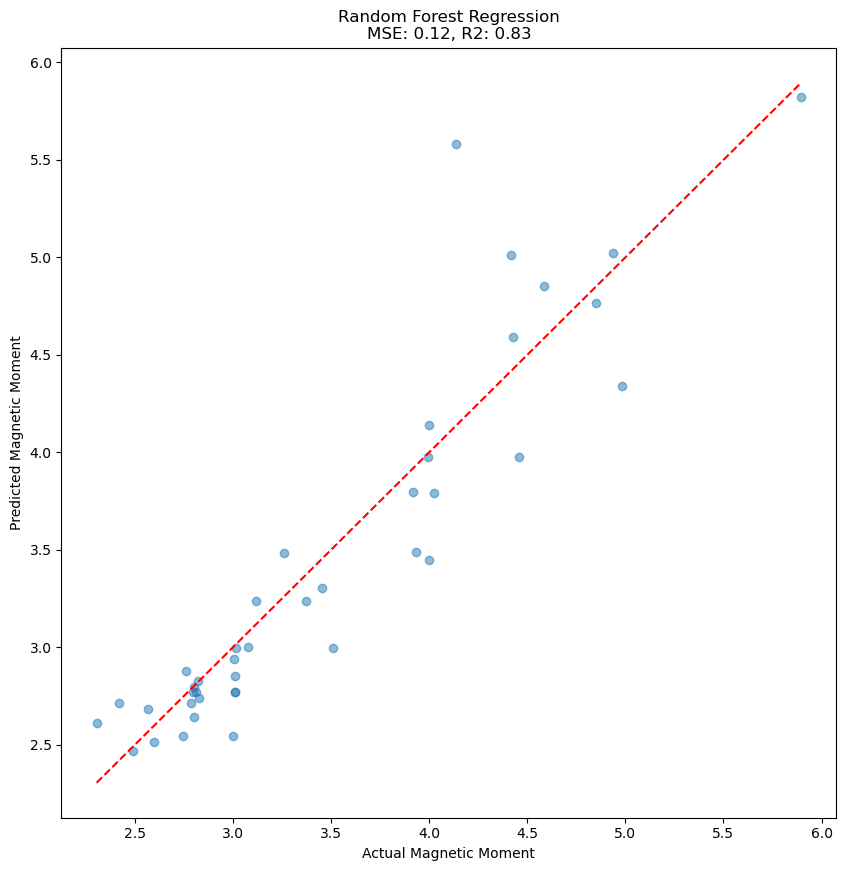

In [483]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

target_column_index = df4.columns.get_loc("atomic_radA1")
X = df4.iloc[:, target_column_index:]
y = df4['magnetic_moment']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest Regressor
rf_regressor.fit(X_train, y_train)

# Generate predictions
y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot the predictions
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.xlabel('Actual Magnetic Moment')
plt.ylabel('Predicted Magnetic Moment')
plt.title(f'Random Forest Regression\nMSE: {mse:.2f}, R2: {r2:.2f}')
plt.show()



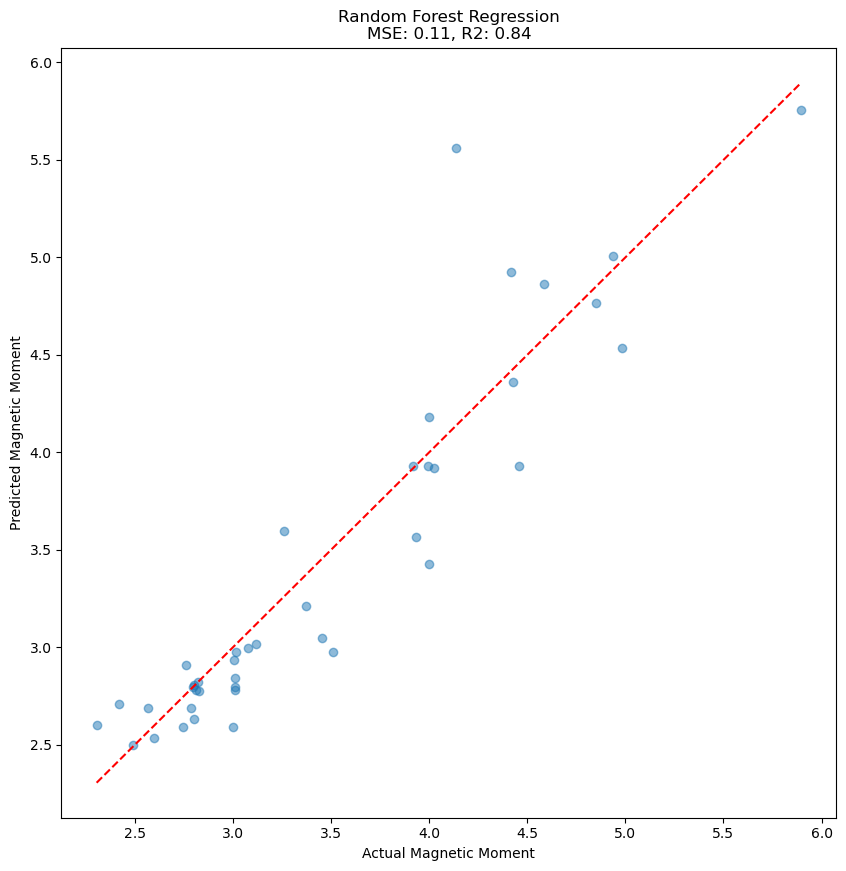

In [375]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.xlabel('Actual Magnetic Moment')
plt.ylabel('Predicted Magnetic Moment')
plt.title(f'Random Forest Regression\nMSE: {mse:.2f}, R2: {r2:.2f}')
plt.show()


In [470]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# import matplotlib.pyplot as plt

# # Assuming you have a dataframe named 'data' and a target column named 'target'
# # Replace 'target' with the actual name of your target column
# target_column_index = df4.columns.get_loc("atomic_radA1")
# X = df4.iloc[:, target_column_index:]
# y = df4['magnetic_moment']
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create a Random Forest classifier
# #rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
# lasso_regressor = Lasso(alpha=.001, random_state=42)

# # Fit the classifier on the training data
# lasso_regressor.fit(X_train, y_train)

# # Get feature importances
# feature_importances = lasso_regressor.coef_

# # Create a dataframe to store feature importances
# feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# # Sort the dataframe by importance in descending order
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Specify the number of top features you want to display
# top_n = 40

# # Get the top N features
# top_features = feature_importance_df.head(top_n)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# Assuming you have a dataframe named 'data' and a target column named 'target'
# Replace 'target' with the actual name of your target column
target_column_index = df4.columns.get_loc("atomic_radA1")
X = df4.iloc[:, target_column_index:]
y = df4['magnetic_moment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the Mutual Information (MI) scores for each feature
mi_scores = mutual_info_regression(X_train, y_train)

# Create a dataframe to store MI scores
mi_df = pd.DataFrame({'Feature': X.columns, 'MI': mi_scores})

# Sort the dataframe by MI score in descending order
mi_df = mi_df.sort_values(by='MI', ascending=False)

# Specify the number of top features you want to select
top_n = 40

# Get the top N features based on MI scores
top_features = mi_df.head(top_n)



Note: you may need to restart the kernel to use updated packages.


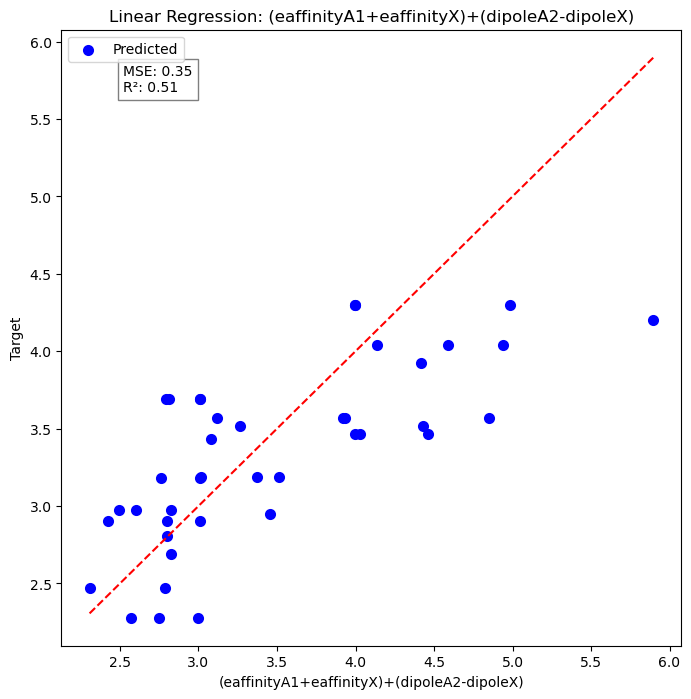

In [466]:
top_n1 = 40

# Get the top N features
top_features1 = mi_df.head(top_n1)

Xhere = X[top_features1["Feature"]]
yhere = y

best_feature = None
best_score = float('inf')  # Initialize with a high value
best_r2 = 0
for feature in Xhere.columns:
    X_feature = Xhere[[feature]]  # Select only the current feature
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.2, random_state=42)
    
    # Create and fit a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    if mse < best_score:
        best_score = mse
        best_r2 = r2
        best_feature = feature

best_feature_data = Xhere[[best_feature]]
X_train, X_test, y_train, y_test = train_test_split(best_feature_data, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure(figsize=(8, 8))
# plt.scatter(X_test, y_test, color='blue', label='Actual')
# plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.scatter(y_test, y_pred, color='blue', linewidth=2, label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.xlabel(best_feature)
plt.ylabel('Target')
plt.title(f'Linear Regression: {best_feature}')
plt.text(0.1, 0.9, f'MSE: {best_score:.2f}\nR²: {best_r2:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.legend()
plt.show()



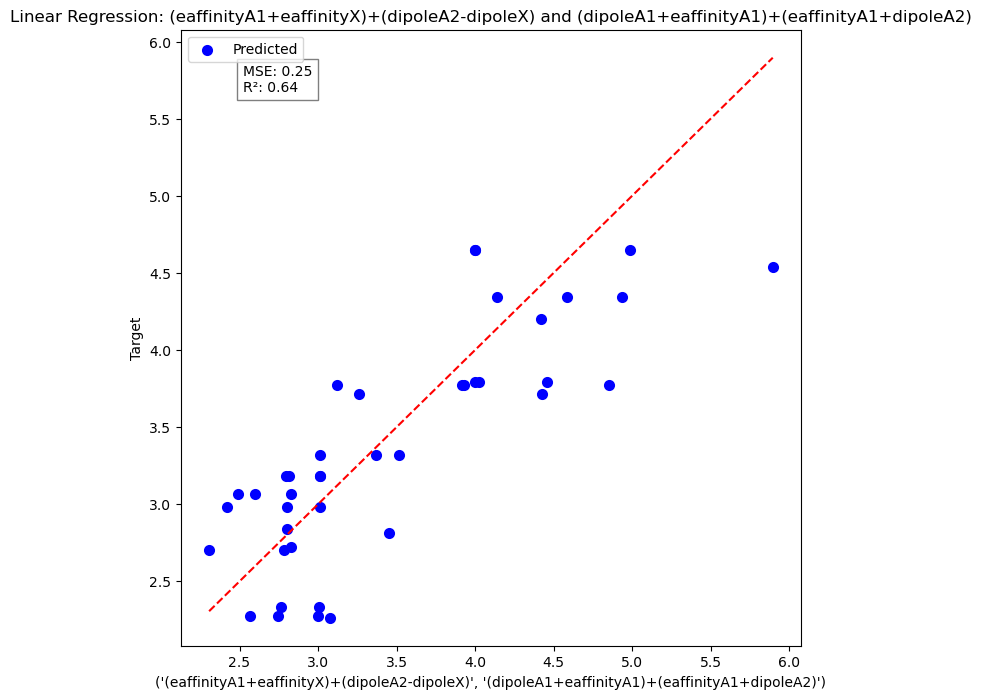

In [467]:
from itertools import combinations

best_features = None
best_score = float('inf')
best_r2 = 0

for feature_pair in combinations(Xhere.columns, 2):
    X_features = Xhere[list(feature_pair)]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    if mse < best_score:
        best_score = mse
        best_r2 = r2
        best_features = feature_pair

best_feature_data = Xhere[list(best_features)]
X_train, X_test, y_train, y_test = train_test_split(best_feature_data, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure(figsize=(8, 8))
# plt.scatter(X_test.iloc[:, 0], y_test, color='blue', label='Actual')
# plt.scatter(X_test.iloc[:, 0], y_pred, color='red', marker='x', label='Predicted')
plt.scatter(y_test, y_pred, color='blue', linewidth=2, label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
str1 = best_features[0], best_features[1]
plt.xlabel(str1)
plt.ylabel('Target')
plt.title(f'Linear Regression: {best_features[0]} and {best_features[1]}')
plt.text(0.1, 0.9, f'MSE: {best_score:.2f}\nR²: {best_r2:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.legend()
plt.show()


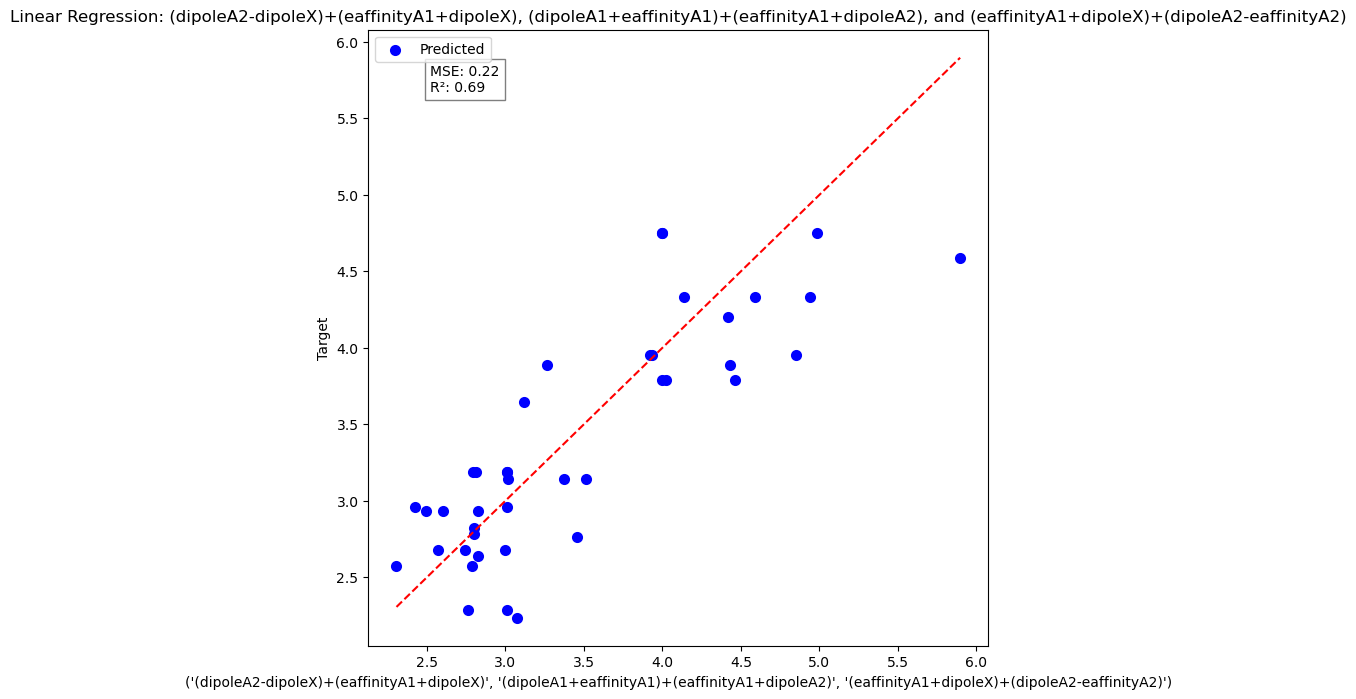

In [468]:
from itertools import combinations

best_features = None
best_score = float('inf')
best_r2 = 0

for feature_trip in combinations(Xhere.columns, 3):
    X_features = Xhere[list(feature_trip)]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    if mse < best_score:
        best_score = mse
        best_r2 = r2
        best_features = feature_trip

best_feature_data = Xhere[list(best_features)]
X_train, X_test, y_train, y_test = train_test_split(best_feature_data, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure(figsize=(8, 8))
# plt.scatter(X_test.iloc[:, 0], y_test, color='blue', label='Actual')
# plt.scatter(X_test.iloc[:, 0], y_pred, color='red', marker='x', label='Predicted')
plt.scatter(y_test, y_pred, color='blue', linewidth=2, label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
str1 = best_features[0], best_features[1], best_features[2]
plt.xlabel(str1)
plt.ylabel('Target')
plt.title(f'Linear Regression: {best_features[0]}, {best_features[1]}, and {best_features[2]}')
plt.text(0.1, 0.9, f'MSE: {best_score:.2f}\nR²: {best_r2:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.legend()
plt.show()


R-squared score: 0.7310997355254027


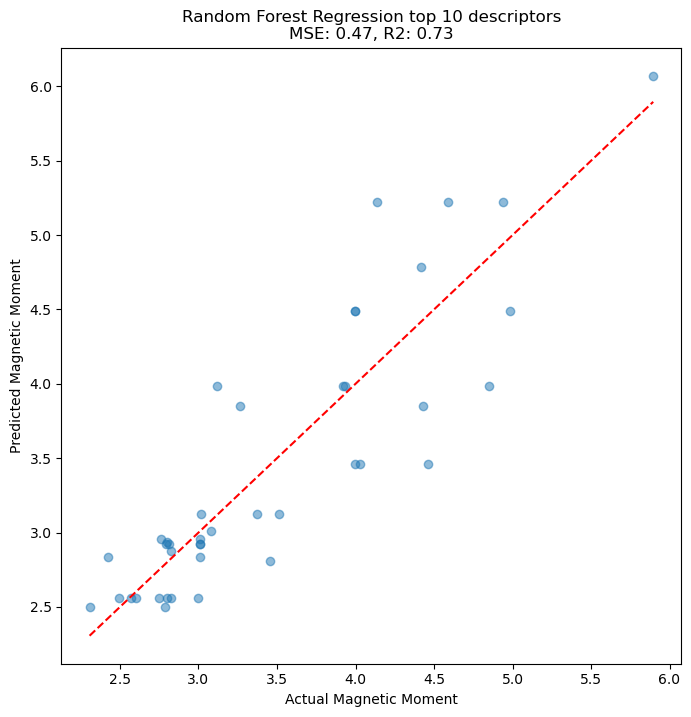

In [471]:
# Subset the training and testing data using the top N features
#print(X_train.iloc[0])
#print(top_features.iloc[0]["Feature"])
top_n1 = 40

# Get the top N features
top_features1 = mi_df.head(top_n1)
#top_features = feature_importance_df.head(10)
X_train_top = X_train[top_features1["Feature"]]
X_test_top = X_test[top_features1["Feature"]]
#print(X_train_top.iloc[0])
# Create a Random Forest regressor using the top N features
rf_regressor = RandomForestRegressor(random_state=42)

# Fit the regressor on the training data
rf_regressor.fit(X_train_top, y_train)

# Make predictions on the test data
y_pred = rf_regressor.predict(X_test_top)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

# Print R-squared score
print(f'R-squared score: {r2}')

# # Plot actual vs. predicted values
# plt.figure(figsize=(8, 6))
# plt.scatter(y_test, y_pred)
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs. Predicted Values')
# plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.xlabel('Actual Magnetic Moment')
plt.ylabel('Predicted Magnetic Moment')
plt.title(f'Random Forest Regression top 10 descriptors\nMSE: {mse:.2f}, R2: {r2:.2f}')
plt.show()


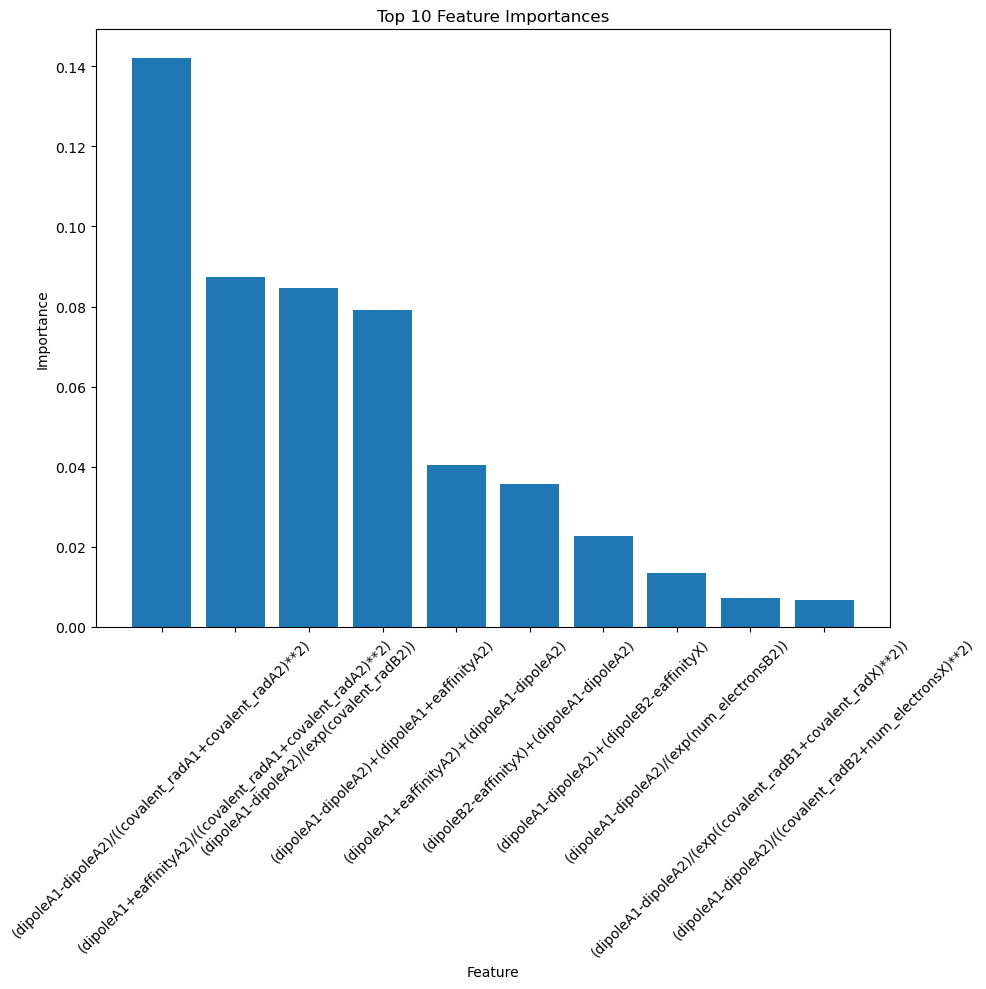

In [397]:
top_n = 10

# Get the top N features
top_features = feature_importance_df.head(top_n)
plt.figure(figsize=(10, 10))
plt.bar(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'Top {top_n} Feature Importances')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [403]:
tmp = feature_importance_df.head(top_n)
for i in range(10):
    print( "Feature ", i+1, "'s name: ", tmp['Feature'].iloc[i], sep='')

Feature 1's name: (dipoleA1-dipoleA2)/((covalent_radA1+covalent_radA2)**2)
Feature 2's name: (dipoleA1+eaffinityA2)/((covalent_radA1+covalent_radA2)**2)
Feature 3's name: (dipoleA1-dipoleA2)/(exp(covalent_radB2))
Feature 4's name: (dipoleA1-dipoleA2)+(dipoleA1+eaffinityA2)
Feature 5's name: (dipoleA1+eaffinityA2)+(dipoleA1-dipoleA2)
Feature 6's name: (dipoleB2-eaffinityX)+(dipoleA1-dipoleA2)
Feature 7's name: (dipoleA1-dipoleA2)+(dipoleB2-eaffinityX)
Feature 8's name: (dipoleA1-dipoleA2)/(exp(num_electronsB2))
Feature 9's name: (dipoleA1-dipoleA2)/(exp((covalent_radB1+covalent_radX)**2))
Feature 10's name: (dipoleA1-dipoleA2)/((covalent_radB2+num_electronsX)**2)
